In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import supervision as sv
import torch
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/MSBuildings')
from build_seg_utils import building_gdf, rel_bbox_coords, rel_polyg_coord, segment_buildings
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/MSRoads')
from road_seg_utils import rel_road_lines, segment_roads, line2points, get_offset_lines, clear_roads, plotPoints, rmv_pts_out_img
import json


In [2]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda:0')

predictor = SamPredictor(sam)

In [3]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')
sample_size = 600
stride = 400
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=stride)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
dataset_crs = dataset.crs
dataset_res = dataset.res

Creazione dataset e indice edifici

In [4]:
gdfs_32628 = building_gdf('TheGambia', root = '/home/vaschetti/maxarSrc/creating_labels/MSBuildings', dataset_crs = dataset_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


Creazione strade

In [5]:
path = '/home/vaschetti/maxarSrc/creating_labels/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)
road_gdf_32628 = road_gdf.to_crs(dataset_crs)

road_point_dist = 40 #50
bg_point_dist = 40 #80
offset_distance = 25 #30

In [6]:
from tqdm import tqdm
from time import time

In [7]:
i = 0
deltas = []
tot_time = []
for batch in tqdm(dataloader):
    if i == 5:
        break
    timetot = time()
    #encode the image
    sample = unbind_samples(batch)[0]
    img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
    time1 = time()
    predictor.set_image(img4Sam)
    delta_t = time() - time1
    deltas.append(delta_t)
    

    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])#get the polygon of the sampled bbox
    
    #buildings
    buildig_hits = index_MS_buildings.query(query_bbox_poly)
    #Getting the relative coordinates of the buildings boxes
    if len(buildig_hits) != 0:
        building_boxes = rel_bbox_coords(gdfs_32628.iloc[buildig_hits], query_bbox_poly.bounds, dataset_res, ext_mt=10)

        building_mask, used_boxes, used_points  =  segment_buildings(predictor, building_boxes,
                                                    img4Sam,
                                                    use_bbox=True,
                                                    use_center_points=False)
    
    #roads
    road_hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    if len(road_hits) != 0:
        queried_road_gdf_36628 = road_gdf_32628[road_hits]
        road_lines = rel_road_lines(queried_road_gdf_36628, query_bbox_poly, dataset_res)

        road_mask, road_pt_coords4Sam, road_pt_labels4Sam = segment_roads(predictor, img4Sam, road_lines,
                                                                                sample_size,
                                                                                road_point_dist = road_point_dist,
                                                                                bg_point_dist = bg_point_dist,
                                                                                offset_distance = offset_distance,
                                                                                do_clean_mask=True)
    tot_time.append(time() - timetot)
    i+=1
    

  0%|          | 0/1936 [00:00<?, ?it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))


  0%|          | 5/1936 [00:13<1:25:06,  2.64s/it]


Plotting

In [8]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/utils')
from plotting_utils import show_mask, show_Linestrings, show_points, show_box, plot_comparison

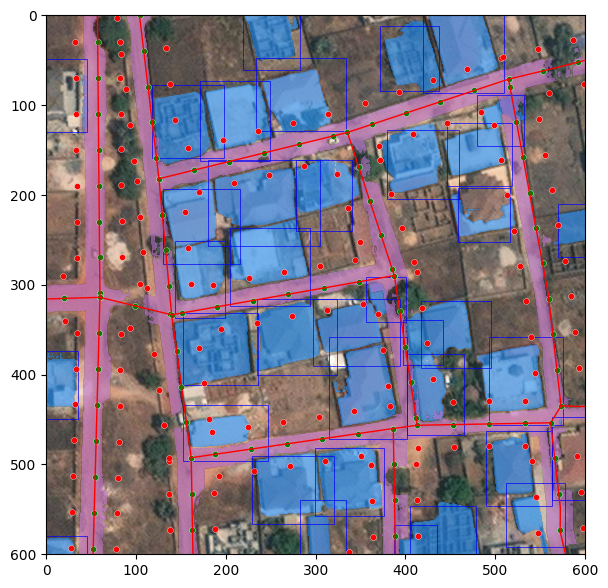

In [13]:
plot_inputs = True
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(img4Sam)

show_mask(building_mask, plt.gca())
show_mask(road_mask, plt.gca(), rgb_color = [182, 112, 202])

if plot_inputs:
    show_Linestrings(road_lines, ax, color='red')
    show_box(used_boxes, ax, color='b')
    show_points(road_pt_coords4Sam, road_pt_labels4Sam, ax)
ax.set_xlim([0, sample_size])
ax.set_ylim([sample_size, 0])
plt.show()


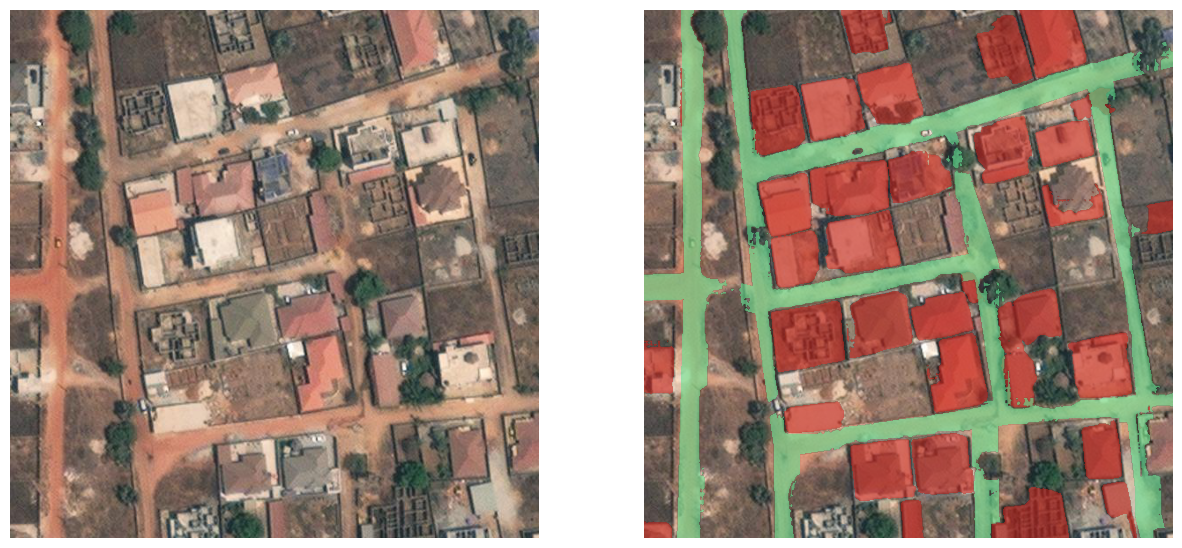

In [10]:
masks = np.vstack((building_mask, road_mask))
plot_comparison(img4Sam, masks)

In [11]:
img_encoding_time = np.array(deltas).mean()

0.8671250451755429

In [12]:
np.array(tot_time).mean()

2.624024200439453